## Caution: important experiment, please do not adjust

The contents within this file are for running a publication-quality experiment and producing the associated figures and results. As such, it is finely tuned for specific high-quality graphics using the `primary.mplstyle` file. Please do not adjust. If you need to replicate results on your local system, please create a new notebook and copy contents from here.

In [1]:
import sys
sys.path.append('../..')  # Expose top level program access

import re
import time
import pickle
import logging
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from sklearn.covariance import EllipticEnvelope
from mpl_toolkits.mplot3d import Axes3D
from functools import reduce
from pathlib import Path
from utils import tools, metrics, supported_preprocessing_transforms
from modules.aae_base_module import AAEBaseModule
from modules.vae_base_module import VAEBaseModule
from models import supported_models
from datasets import supported_datamodules
from scipy.stats import gaussian_kde
from utils.dtypes import *

logging.getLogger("matplotlib").setLevel(logging.WARNING)  # Suppress verbose font warnings from matplotlib

In [2]:
# import configurations and paths to logged models
root = Path.cwd().parents[1]
log_path = root / 'logs' / 'LunarAnalogueDataModule'
paths_to_archived_models = list(Path(log_path).glob('**/archive_v*'))

# filter the models that don't provide structured latent representations
for i, p in enumerate(paths_to_archived_models.copy()):
    if not re.search('VAE|AAE', str(p)):
        paths_to_archived_models.remove(p)

print('Found archived models:\n------')
print('\n'.join([f'{p.parent.name}/{p.name}' for p in paths_to_archived_models]))

Found archived models:
------
BaselineVAE/archive_v2_2021-05-06
BaselineVAE/archive_v1_2021-05-06
BaselineAAE/archive_v1_2021-05-06


In [3]:
from experiments.helpers import load_modules

module_catalog, datamodule, _ = load_modules(paths_to_archived_models)

Loading state dict for: BaselineVAE/archive_v2_2021-05-06
Loading state dict for: BaselineVAE/archive_v1_2021-05-06
Loading state dict for: BaselineAAE/archive_v1_2021-05-06


In [4]:
# Collect scores and labels on test set for all models and save to a dictionary
result_catalog = {}

for model_type, model_variants in module_catalog.items():
    start_time = time.time()
    
    for model_name, module in model_variants.items():
        
        latent_vecs = []
        test_novelty_scores = []
        test_novelty_labels = []
        short_name = model_type + '-' + model_name.split('_')[1]
        print(f'------\n{short_name}\n------')
        
        if short_name not in result_catalog:
            result_catalog[short_name] = {
                'latent_vecs': [],
                'scores':      [], 
                'labels':      []
            }
        
        # Set the model/components to evaluation mode
        if 'AAE' in model_type:
            module.encoder.eval()
            module.decoder.eval()
        else:
            module.model.eval()

        with torch.no_grad():
            for batch_nb, batch in enumerate(datamodule.test_dataloader()):

                result = module.test_step(batch, batch_nb)
                
                # Populate results
                latent_vecs.extend(result['images']['batch_lt'].cpu().numpy())
                test_novelty_scores.extend(result['scores'])
                test_novelty_labels.extend(result['labels'].cpu().numpy())                
                print(f'[BATCH {batch_nb}] Mean score: {np.mean(result["scores"])}')
                    
        result_catalog[short_name]['latent_vecs'] = latent_vecs
        result_catalog[short_name]['scores'] = test_novelty_scores
        result_catalog[short_name]['labels'] = test_novelty_labels
        print(f'{short_name} Time: {time.time() - start_time:.2f} s\n')

------
BaselineVAE-v2
------
[BATCH 0] Mean score: 0.6422308683395386
[BATCH 1] Mean score: 0.6402462720870972
[BATCH 2] Mean score: 0.6947313547134399
[BATCH 3] Mean score: 0.6555516719818115
[BATCH 4] Mean score: 0.7114335298538208
[BATCH 5] Mean score: 0.6629235744476318
[BATCH 6] Mean score: 0.6162129640579224
[BATCH 7] Mean score: 0.6469911336898804
[BATCH 8] Mean score: 0.7110438942909241
[BATCH 9] Mean score: 0.6811044216156006
[BATCH 10] Mean score: 0.6913731098175049
[BATCH 11] Mean score: 0.6782835721969604
[BATCH 12] Mean score: 0.6645971536636353
[BATCH 13] Mean score: 0.6957767605781555
[BATCH 14] Mean score: 0.7113751769065857
[BATCH 15] Mean score: 0.7114408612251282
[BATCH 16] Mean score: 0.687830924987793
[BATCH 17] Mean score: 0.6584557294845581
[BATCH 18] Mean score: 0.6749122142791748
[BATCH 19] Mean score: 0.6734520196914673
[BATCH 20] Mean score: 0.7203084230422974
[BATCH 21] Mean score: 0.7122122049331665
[BATCH 22] Mean score: 0.7065367102622986
[BATCH 23] Mean 

2021-05-19 17:08:04,541 - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2021-05-19 17:08:07,062 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:08:07,063 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:08:07,064 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:08:07,065 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:08:07,065 - DEBUG - STREAM b'IDAT' 149 74
2021-05-19 17:08:07,090 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:08:07,092 - DEBUG - STREAM b'PLTE' 41 39
2021-05-19 17:08:07,094 - DEBUG - STREAM b'tRNS' 92 12
2021-05-19 17:08:07,095 - DEBUG - STREAM b'pHYs' 116 9
2021-05-19 17:08:07,098 - DEBUG - STREAM b'IDAT' 137 43
2021-05-19 17:08:07,105 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:08:07,107 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:08:07,108 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:08:07,111 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:08:07,113 - DEBUG - STREAM b'IDAT' 149 67
2021-05-19 17:08:07,119 - DEBUG - STREAM b'IHDR' 16 13
2021-05

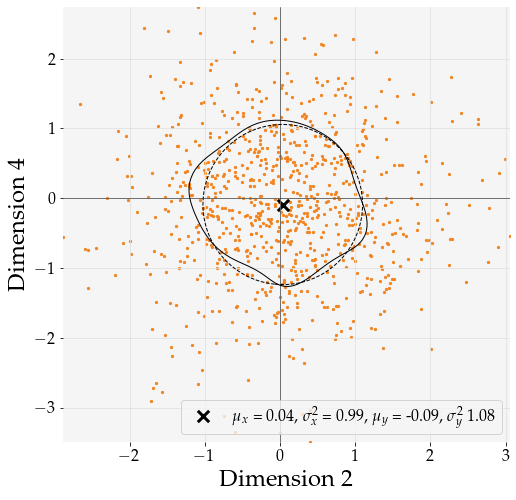

2021-05-19 17:08:08,541 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:08:08,543 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:08:08,543 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:08:08,543 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:08:08,544 - DEBUG - STREAM b'IDAT' 149 166
2021-05-19 17:08:08,556 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:08:08,557 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:08:08,557 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:08:08,557 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:08:08,558 - DEBUG - STREAM b'IDAT' 149 137
2021-05-19 17:08:08,560 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:08:08,560 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:08:08,560 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:08:08,561 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:08:08,561 - DEBUG - STREAM b'IDAT' 149 133
2021-05-19 17:08:08,568 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:08:08,568 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:08:08,569 - DEBUG - STREAM b'tRNS' 101 15


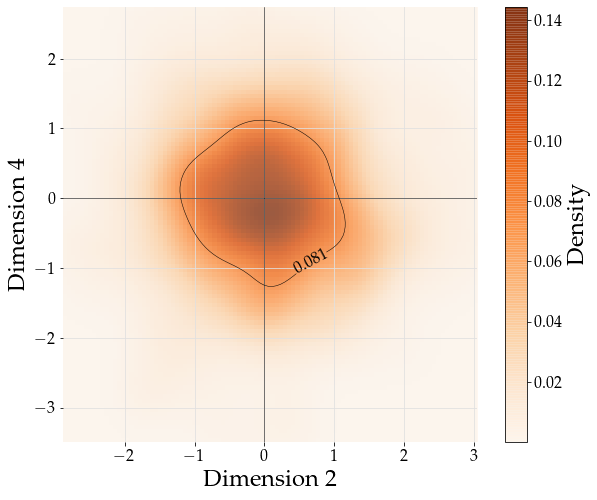

2021-05-19 17:08:09,313 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:08:09,314 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:08:09,314 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:08:09,315 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:08:09,315 - DEBUG - STREAM b'IDAT' 149 822


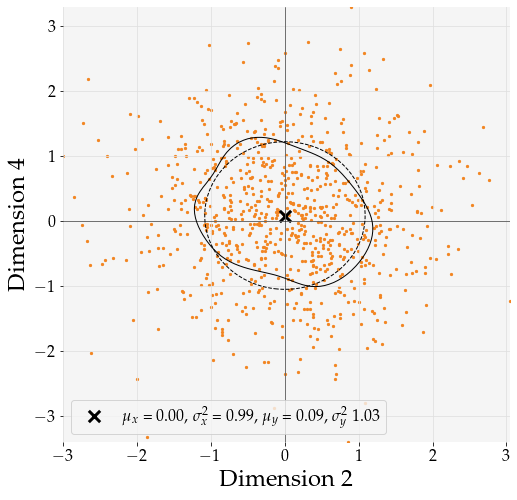

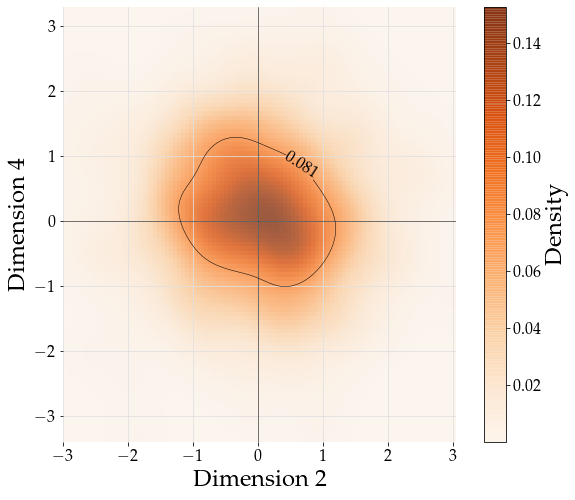

2021-05-19 17:08:10,298 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:08:10,299 - DEBUG - STREAM b'PLTE' 41 42
2021-05-19 17:08:10,300 - DEBUG - STREAM b'tRNS' 95 13
2021-05-19 17:08:10,300 - DEBUG - STREAM b'pHYs' 120 9
2021-05-19 17:08:10,300 - DEBUG - STREAM b'IDAT' 141 55
2021-05-19 17:08:10,436 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:08:10,436 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:08:10,437 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:08:10,437 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:08:10,437 - DEBUG - STREAM b'IDAT' 149 970


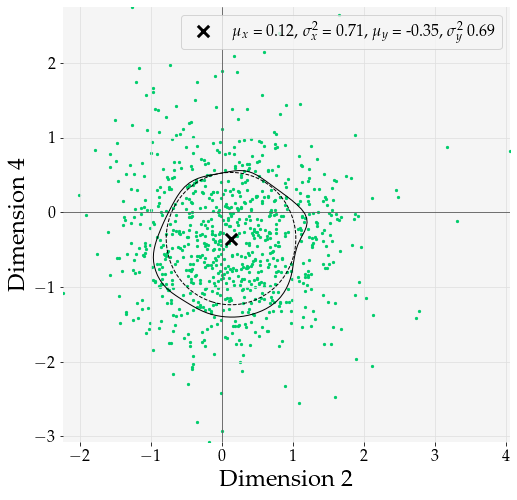

2021-05-19 17:08:11,055 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:08:11,056 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:08:11,057 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:08:11,057 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:08:11,058 - DEBUG - STREAM b'IDAT' 149 168
2021-05-19 17:08:11,072 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:08:11,072 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:08:11,072 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:08:11,073 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:08:11,073 - DEBUG - STREAM b'IDAT' 149 118
2021-05-19 17:08:11,075 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:08:11,076 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:08:11,076 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:08:11,076 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:08:11,077 - DEBUG - STREAM b'IDAT' 149 181
2021-05-19 17:08:11,078 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:08:11,079 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:08:11,079 - DEBUG - STREAM b'tRNS' 101 15


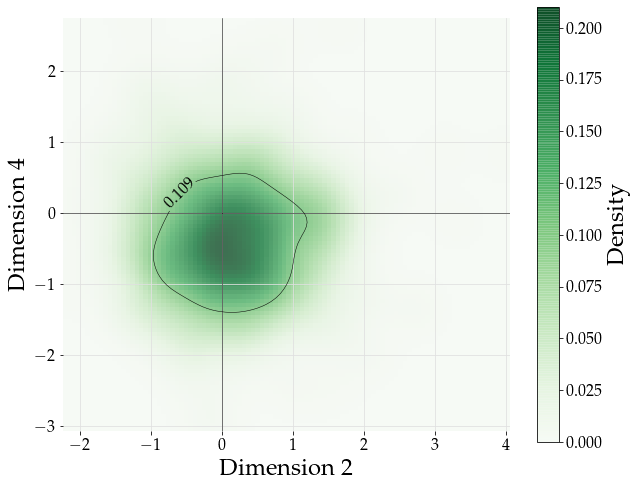

In [5]:
def gaussian2d(x, y, x_mu, x_var, y_mu, y_var):
    arg_x = (x - x_mu)**2 / (2*x_var**2)
    arg_y = (y - y_mu)**2 / (2*y_var**2)    
    return np.exp(-(arg_x + arg_y))

def fwhm(std):
    return 2*np.sqrt(2*np.log(2))*std

# Use standard custom styling
plt.style.use('../../utils/_extras/primary.mplstyle')

def latent_vis_2d(latent_vecs, dim_x: int = 2, dim_y: int = 4, save_name=None, color='C1', show_plots=True):

    # Code for setting up advanced plotting and graphing
    x_mean, x_var = latent_vecs[:, dim_x].mean(), latent_vecs[:, dim_x].var()
    y_mean, y_var = latent_vecs[:, dim_y].mean(), latent_vecs[:, dim_y].var()
    kde = gaussian_kde(latent_vecs[:, [dim_x, dim_y]].T)

    x_steps = np.linspace(latent_vecs[:, dim_x].min(), latent_vecs[:, dim_x].max(), 100)
    y_steps = np.linspace(latent_vecs[:, dim_y].min(), latent_vecs[:, dim_y].max(), 100)
    X, Y = np.meshgrid(x_steps, y_steps)
    Z = kde.evaluate(np.vstack([X.ravel(), Y.ravel()]))



    Zgaussian = gaussian2d(X, Y, x_mean, x_var, y_mean, y_var)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(latent_vecs[:, dim_x], latent_vecs[:, dim_y], s=5, alpha=1., color=color)

    ax.contour(
        X, Y, Zgaussian, levels=[fwhm(Zgaussian.std())], 
        colors='k', linewidths=1., linestyles='--', alpha=1.0)
    ax.contour(
        X, Y, Z.reshape(X.shape), levels=[fwhm(Z.std())], 
        colors='k', linewidths=1., linestyles='-', alpha=1.0)

    ax.scatter([x_mean], [y_mean], color='k', marker='x', s=2**7, 
                label=r'$\mu_x$ = {:.2f}, $\sigma^2_x$ = {:.2f}, $\mu_y$ = {:.2f}, $\sigma^2_y$ {:.2f}'.format(x_mean, x_var, y_mean, y_var))

    ax.axhline(0, 0, c='k', lw=0.5)
    ax.axvline(0, 0, c='k', lw=0.5)
    ax.legend()
    ax.set_xlabel(f'Dimension {dim_x}')
    ax.set_ylabel(f'Dimension {dim_y}')

    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'LatentScatter-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    cb = ax.imshow(Z.reshape(X.shape), cmap='Oranges' if color=='C6' else 'Greens', 
              extent=[x_steps[0], x_steps[-1], y_steps[0], y_steps[-1]], origin='lower', alpha=0.75)
    c = ax.contour(X, Y, Z.reshape(X.shape), colors='k', levels=[fwhm(Z.std())], linewidths=0.5)

    ax.axhline(0, 0, c='k', lw=0.5)
    ax.axvline(0, 0, c='k', lw=0.5)
    ax.set_xlabel(f'Dimension {dim_x}')
    ax.set_ylabel(f'Dimension {dim_y}')
    ax.clabel(c, fontsize=16)
    
    cb = fig.colorbar(cb)
    cb.set_label('Density')
    
    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'LatentKDE-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()
    
for sn, res in result_catalog.items():
    lt_vecs = np.stack(res['latent_vecs'], axis=0)
    color = 'C1' if 'AAE' in sn else 'C6'
    latent_vis_2d(lt_vecs, save_name=sn, color=color)

2021-05-19 17:09:22,537 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:09:22,537 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:09:22,538 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:09:22,538 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:09:22,539 - DEBUG - STREAM b'IDAT' 149 200
2021-05-19 17:09:22,544 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:09:22,545 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:09:22,546 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:09:22,546 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:09:22,546 - DEBUG - STREAM b'IDAT' 149 268


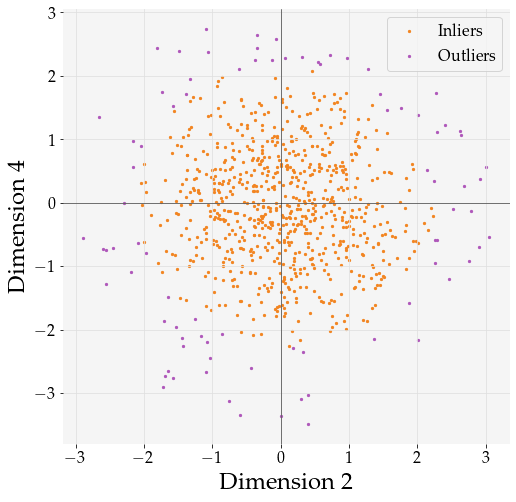

2021-05-19 17:09:23,166 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:09:23,167 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:09:23,167 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:09:23,168 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:09:23,168 - DEBUG - STREAM b'IDAT' 149 96
2021-05-19 17:09:23,170 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:09:23,170 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:09:23,171 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:09:23,171 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:09:23,171 - DEBUG - STREAM b'IDAT' 149 98
2021-05-19 17:09:23,173 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:09:23,174 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:09:23,174 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:09:23,174 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:09:23,175 - DEBUG - STREAM b'IDAT' 149 129
2021-05-19 17:09:23,177 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:09:23,177 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:09:23,178 - DEBUG - STREAM b'tRNS' 101 15
20

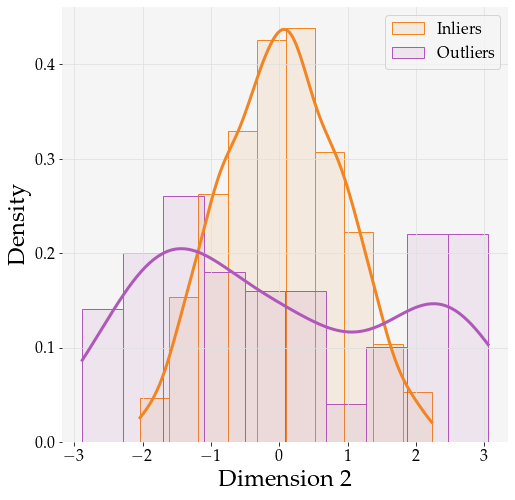

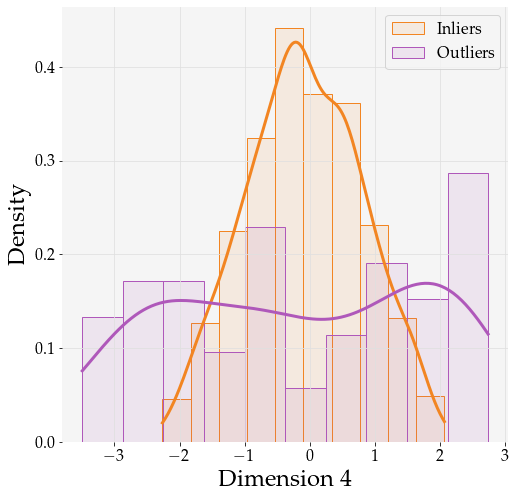

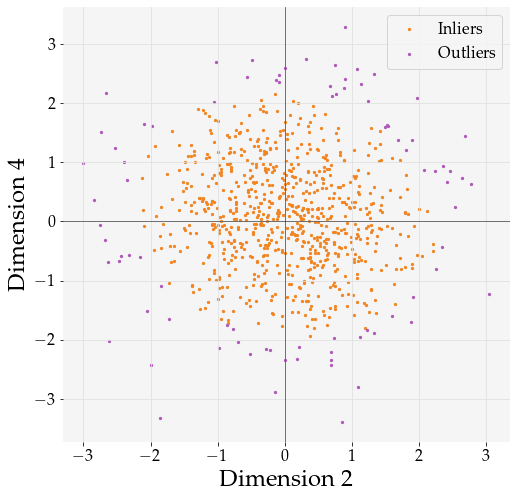

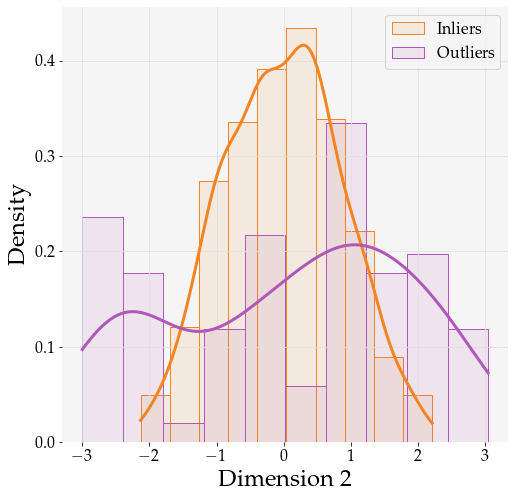

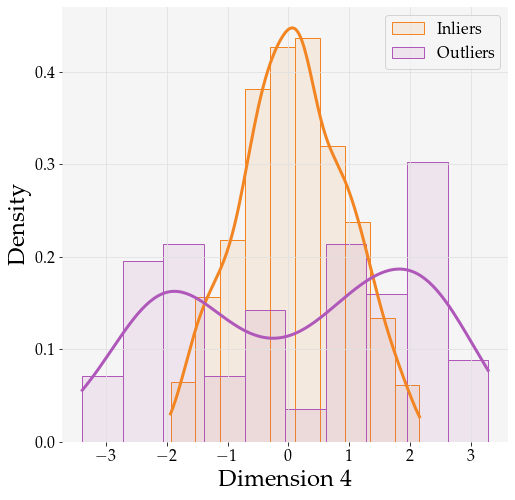

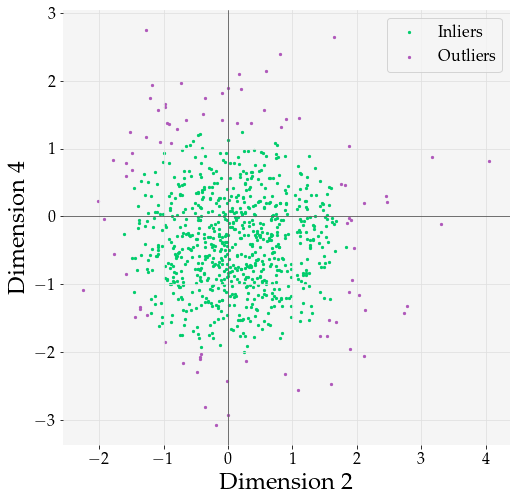

2021-05-19 17:09:25,977 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:09:25,977 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:09:25,977 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:09:25,978 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:09:25,978 - DEBUG - STREAM b'IDAT' 149 127


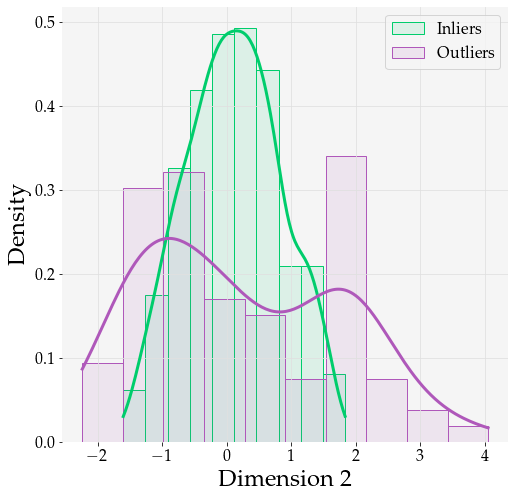

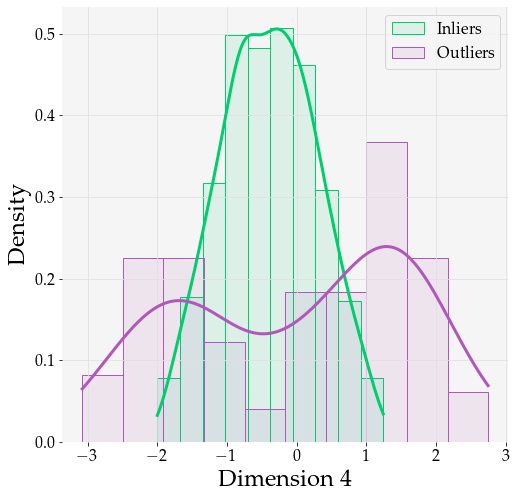

In [6]:
def latent_vis_envelope_2d(latent_vecs, dim_x: int = 2, dim_y: int = 4, save_name=None, stat='density', color='C1'):

    dim_x = 2
    dim_y = 4
    cov_2d = EllipticEnvelope(random_state=49).fit(latent_vecs[:, [dim_x, dim_y]])
    pred_2d = cov_2d.predict(latent_vecs[:, [dim_x, dim_y]])

    inliers_2d = ((pred_2d + 1) // 2).astype(bool)
    outliers_2d = ~inliers_2d
    
    # Plot the 2d results
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(latent_vecs[inliers_2d, dim_x], latent_vecs[inliers_2d, dim_y], s=5, label='Inliers', color=color)
#     ax.scatter(latent_vecs[np.array(labels).astype(bool), dim_x], latent_vecs[np.array(labels).astype(bool), dim_y],
#                s=5, label='Novelties', color='C5')  # This line is for seeing the distr. of novelties
    ax.scatter(latent_vecs[outliers_2d, dim_x], latent_vecs[outliers_2d, dim_y], s=5, label='Outliers', color='C3')

    
    ax.axhline(0, 0, c='k', lw=0.5)
    ax.axvline(0, 0, c='k', lw=0.5)
    ax.set_xlabel(f'Dimension {dim_x}')
    ax.set_ylabel(f'Dimension {dim_y}')
    ax.legend()
    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'2dOutliers-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()

    # Plot x dimension
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.histplot(data=latent_vecs[inliers_2d, dim_x], bins=10, alpha=0.1, stat=stat, 
                 kde=True, color=color, edgecolor=color, label='Inliers')
    sns.histplot(data=latent_vecs[outliers_2d, dim_x], bins=10, alpha=0.1, stat=stat,
                 kde=True, color='C3', edgecolor='C3', label='Outliers')
    
    ax.set_xlabel(f'Dimension {dim_x}')
    ax.legend()
    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'InlierOutlierDensityX-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()

    # Plot y dimension
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.histplot(data=latent_vecs[inliers_2d, dim_y], bins=10, alpha=0.1, stat=stat,
                 kde=True, color=color, edgecolor=color, label='Inliers')
    sns.histplot(data=latent_vecs[outliers_2d, dim_y], bins=10, alpha=0.1, stat=stat, 
                 kde=True, color='C3', edgecolor='C3', label='Outliers')
    ax.set_xlabel(f'Dimension {dim_y}')
    ax.legend()
    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'InlierOutlierDensityY-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()
    
    # Here, the negative mahalanobis distance is used as the novelty score
    return -cov_2d.mahalanobis(latent_vecs[:, [dim_x, dim_y]])

# Use the negative Mahalanobis distance as the novelty score
latent_scores_catalog = {}

for sn, res in result_catalog.items():
    lt_vecs = np.stack(res['latent_vecs'], axis=0)
    color = 'C1' if 'AAE' in sn else 'C6'
    scores_2d = latent_vis_envelope_2d(lt_vecs, save_name=sn, color=color)
    latent_scores_catalog[f'{sn}-2d'] = scores_2d

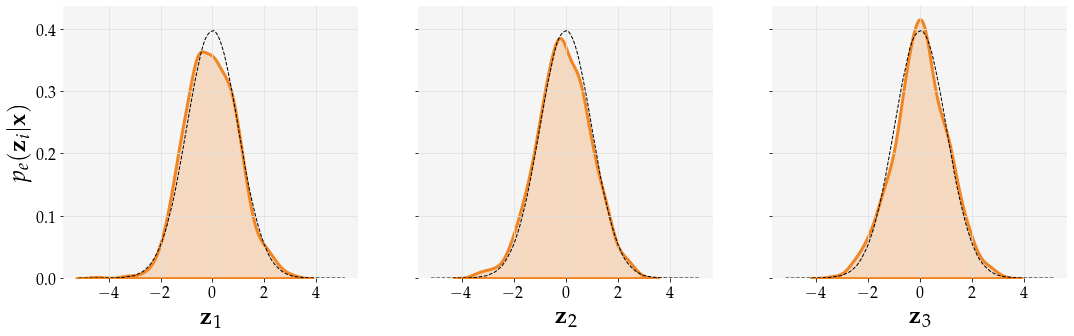

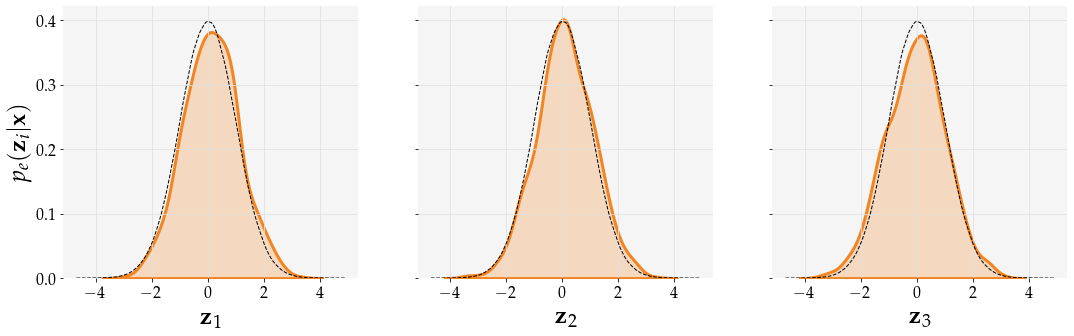

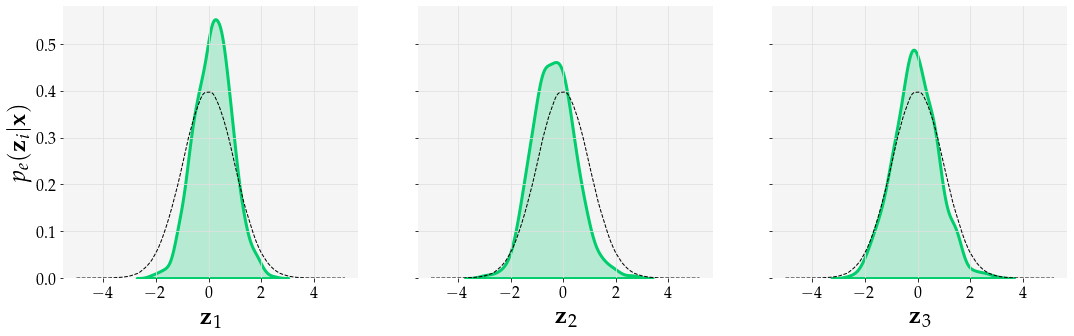

In [25]:
def latent_vis_envelope_nd(latent_vecs, dim_x: int = 2, dim_y: int = 4, save_name=None, color='C1'):

    cov = EllipticEnvelope(random_state=49).fit(latent_vecs)

    pred = cov.predict(latent_vecs)
    standard_normal = np.random.normal(0., 1., 1000000)

    inliers = ((pred + 1) // 2).astype(bool)
    outliers = ~inliers

    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18,5))
    sns.kdeplot(ax=ax[0], data=standard_normal, color='k', lw=1, ls='--')
    sns.kdeplot(ax=ax[0], data=latent_vecs[:, 3], fill=True, lw=3, color=color)
    ax[0].set_ylabel('$p_{e}(\\mathbf{z}_i|\\mathbf{x})$')
    ax[0].set_xlabel('$\\mathbf{z}_1$')
    
    sns.kdeplot(ax=ax[1], data=standard_normal, color='k', lw=1, ls='--')
    sns.kdeplot(ax=ax[1], data=latent_vecs[:, 4], fill=True, lw=3, color=color)
    ax[1].set_xlabel('$\\mathbf{z}_2$')
    
    sns.kdeplot(ax=ax[2], data=standard_normal, color='k', lw=1, ls='--')
    sns.kdeplot(ax=ax[2], data=latent_vecs[:, 5], fill=True, lw=3, color=color)
    ax[2].set_xlabel('$\\mathbf{z}_3$')
    plt.show()
    
    # Here, the negative mahalanobis distance is used as the novelty score
#     return -cov.mahalanobis(latent_vecs)
    return cov.score_samples(latent_vecs)
    
for sn, res in result_catalog.items():
    lt_vecs = np.stack(res['latent_vecs'], axis=0)
    color = 'C1' if 'AAE' in sn else 'C6'
    scores_nd = latent_vis_envelope_nd(lt_vecs, save_name=sn, color=color)
    latent_scores_catalog[f'{sn}-nd'] = scores_nd

2021-05-19 17:39:29,180 - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2021-05-19 17:39:32,712 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:39:32,715 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:39:32,716 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:39:32,717 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:39:32,719 - DEBUG - STREAM b'IDAT' 149 127
2021-05-19 17:39:32,733 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:39:32,734 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:39:32,735 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:39:32,736 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:39:32,738 - DEBUG - STREAM b'IDAT' 149 128
2021-05-19 17:39:32,747 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:39:32,749 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:39:32,750 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:39:32,752 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:39:32,753 - DEBUG - STREAM b'IDAT' 149 97
2021-05-19 17:39:32,786 - DEBUG - STREAM b'IHDR' 16 13
2021

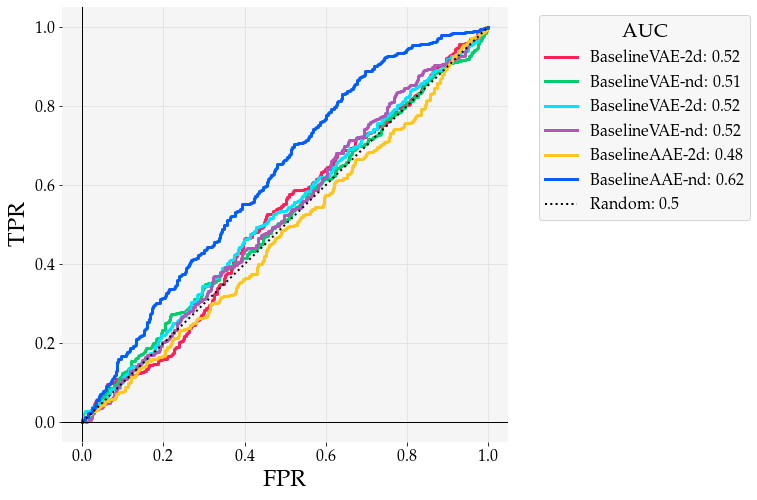

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))

for sn in result_catalog:
    for suf in ['2d', 'nd']:
        scores = latent_scores_catalog[f'{sn}-{suf}']
        fpr, tpr, thresholds, auc = metrics.roc(scores, result_catalog[sn]['labels'])

        ax.plot(fpr, tpr, label=f'{sn.split("-")[0]}-{suf}: {auc:.2f}')
    

ax.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random: 0.5')
ax.legend(title='AUC', bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.axhline(0, 0, c='k', lw=1)
ax.axvline(0, 0, c='k', lw=1)

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

plt.savefig('ROC-latentspace_LunarAnalogueLandscape.pdf', format='pdf', bbox_inches='tight')
plt.show()

2021-05-19 17:40:31,086 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:40:31,086 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:40:31,087 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:40:31,087 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:40:31,087 - DEBUG - STREAM b'IDAT' 149 398
2021-05-19 17:40:31,101 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:40:31,101 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:40:31,102 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:40:31,102 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:40:31,102 - DEBUG - STREAM b'IDAT' 149 156
2021-05-19 17:40:31,113 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:40:31,115 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:40:31,117 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 17:40:31,118 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 17:40:31,121 - DEBUG - STREAM b'IDAT' 149 109
2021-05-19 17:40:31,163 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 17:40:31,164 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 17:40:31,165 - DEBUG - STREAM b'tRNS' 101 15


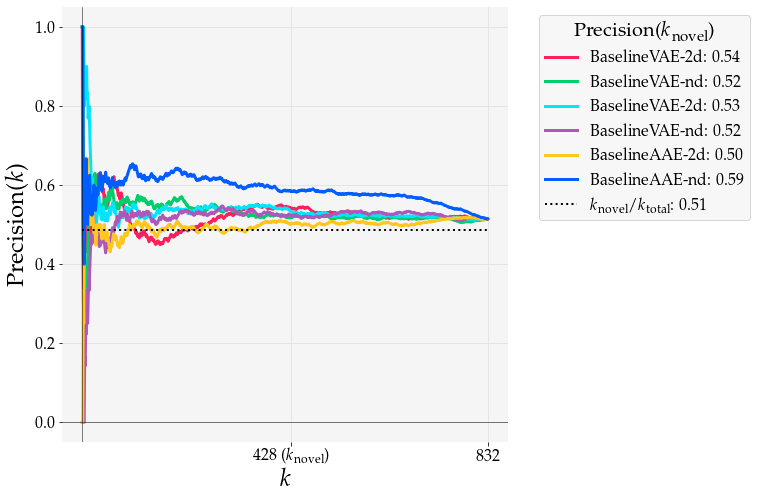

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))

for sn in result_catalog:
    for suf in ['2d', 'nd']:
        scores = latent_scores_catalog[f'{sn}-{suf}']


        pak = metrics.precision_at_k(scores, result_catalog[sn]['labels'])

        uniques, counts = np.unique(result_catalog[sn]['labels'], return_counts=True)
        random = counts.min() / counts.sum()

        ax.plot(pak, label=f'{sn.split("-")[0]}-{suf}: {pak[int(sum(result_catalog[sn]["labels"]))]:.2f}')
    
ax.plot([0, len(pak)], [random, random], 'k:', lw=2, 
        label='$k_{\mathrm{novel}}/k_{\mathrm{total}}$: '+f'{counts[1]/counts.sum():.2f}')

ax.set_xlabel('$k$')
ax.set_ylabel('Precision($k$)')
ax.legend(title='Precision($k_{\mathrm{novel}}$)', bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.set_xticks([counts[1], counts.sum()])
ax.set_xticklabels([str(counts[1])+' ($k_{\mathrm{novel}}$)', counts.sum()])

# Draw axes for styling
ax.axhline(0, 0, c='k', lw=0.5)
ax.axvline(0, 0, c='k', lw=0.5)

plt.savefig('Pak-latentspace_LunarAnalogueLandscape.pdf', format='pdf', bbox_inches='tight')
plt.show()

BaselineVAE-v2


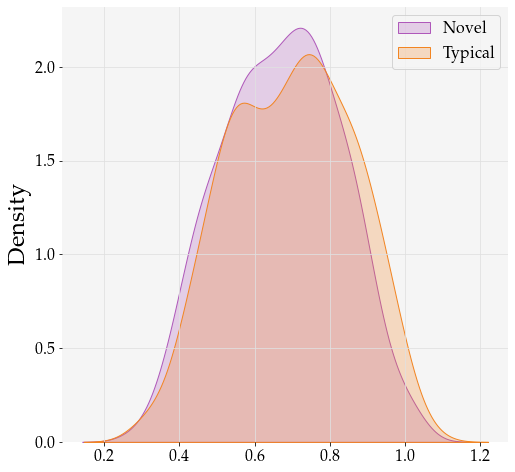

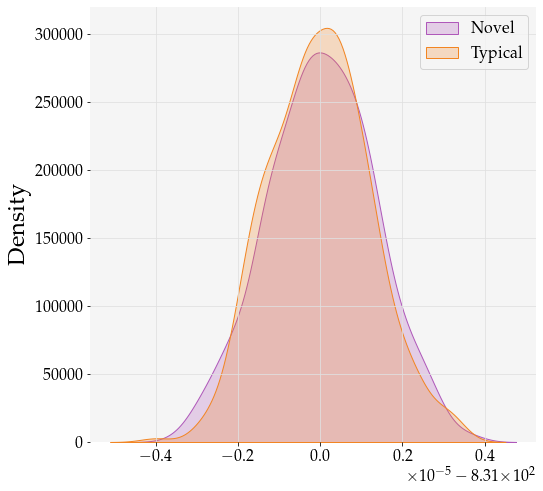

BaselineVAE-v1


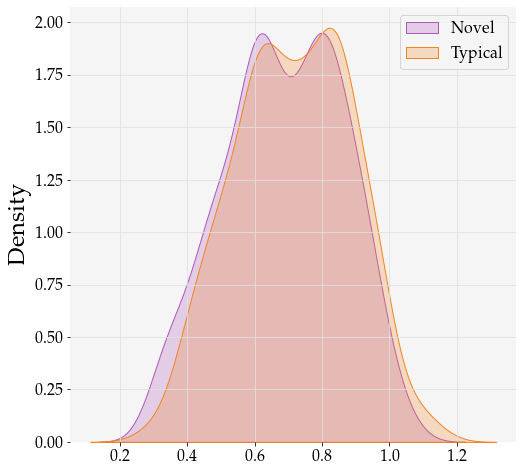

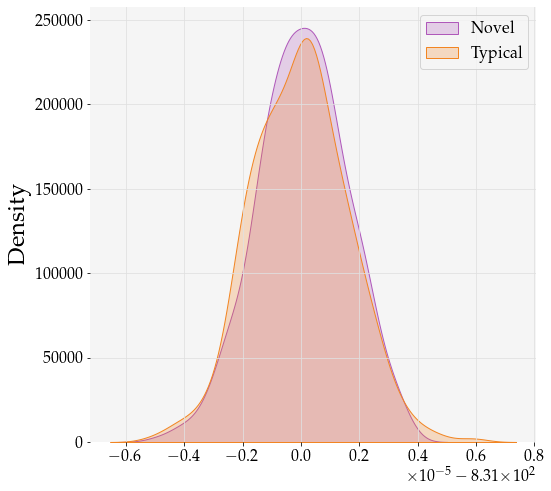

BaselineAAE-v1


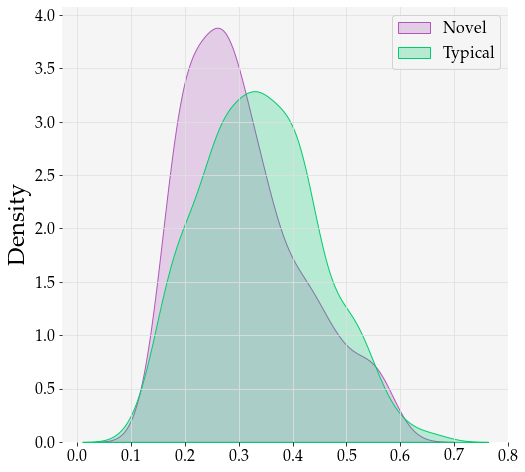

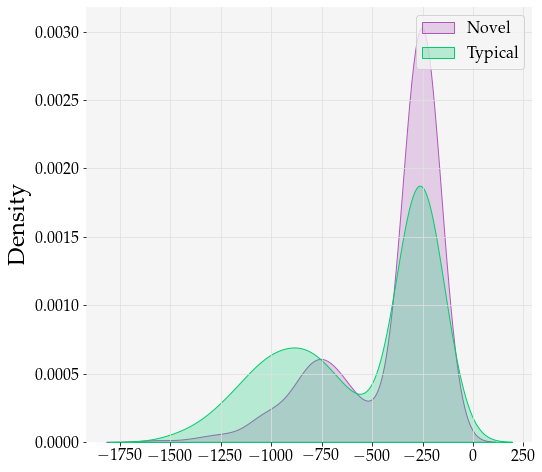

In [53]:
def score_density_vis(lt_scores, rc_scores, labels, sn, color='C1'):
    
    labels = np.array(labels).astype(bool)
    lt_scores = np.array(lt_scores)
    rc_scores = np.array(rc_scores)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.kdeplot(data=rc_scores[labels], label='Novel', color='C3', fill=True)
    sns.kdeplot(data=rc_scores[~labels], label='Typical', color=color, fill=True)
    plt.legend()
    plt.savefig(f'ReconstructionScoreDensity-{sn}-LunarAnalogueLandscape.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.kdeplot(data=lt_scores[labels], label='Novel', color='C3', fill=True, common_norm=True)
    sns.kdeplot(data=lt_scores[~labels], label='Typical', color=color, fill=True, common_norm=True)
    plt.legend()
    plt.savefig(f'LatentScoreDensity-{sn}-LunarAnalogueLandscape.pdf', format='pdf', bbox_inches='tight')
    plt.show()

for sn, res in result_catalog.items():
    print(sn)
            
    lt_scores = latent_scores_catalog[f'{sn}-nd']
    rc_scores = res['scores']
    color = 'C1' if 'AAE' in sn else 'C6'
    score_density_vis(lt_scores, rc_scores, res['labels'], sn, color=color)